In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/FINAL_TF2_FILES/TF_2_Notebooks_and_Data/DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [5]:
df.columns = ['Production']

In [6]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [7]:
df.shape

(573, 1)

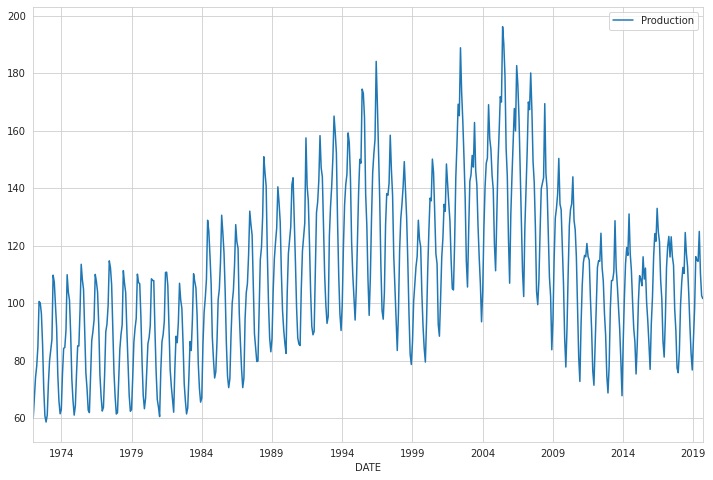

In [ ]:
df.plot(figsize=(12,8))

Train Test Split

In [ ]:
len(df)

573

In [ ]:
test_size = 24

In [ ]:
test_ind = len(df)- test_size # test index

In [ ]:
train = df.iloc[:test_ind] # training set
test = df.iloc[test_ind:] # testing set is last 24 values

Scale Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
length = 24
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

Create the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(125, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 125)               63500     
_________________________________________________________________
dense (Dense)                (None, 1)                 126       
Total params: 63,626
Trainable params: 63,626
Non-trainable params: 0
_________________________________________________________________


In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=20, batch_size=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
model.fit_generator(generator,epochs=25,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
525/525 [==============================] - 8s 12ms/step - loss: 0.0409 - val_loss: 0.0076
Epoch 2/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0175 - val_loss: 0.0018
Epoch 3/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 4/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 5/25
525/525 [==============================] - 6s 11ms/step - loss: 0.0033 - val_loss: 0.0027


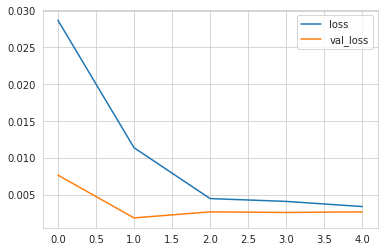

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

Evaluate on Test Data

In [ ]:
test_predictions = []
 
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,87.046764
2017-11-01,77.4378,78.991497
2017-12-01,75.8118,78.338575
2018-01-01,83.4343,86.897043
2018-02-01,99.4899,98.896286
2018-03-01,107.3152,109.184373
2018-04-01,112.4309,116.974730
2018-05-01,110.3544,121.771335
2018-06-01,124.5841,122.278106


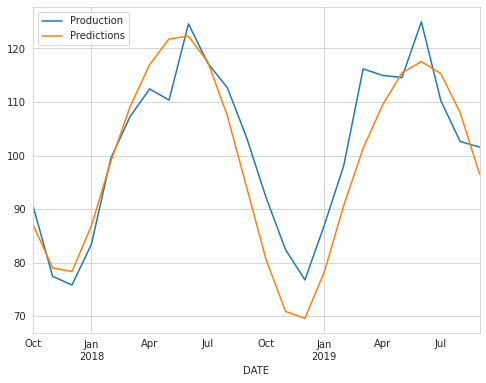

In [ ]:
test.plot(figsize=(8,6))

In [ ]:
from sklearn import metrics

In [ ]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(test['Production'], test['Predictions'])))

RMSE: 6.903275573052721


Forecast

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 20 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(125, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
 
 
# fit model
model.fit_generator(generator,epochs=12)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
553/553 [==============================] - 6s 9ms/step - loss: 0.0329
Epoch 2/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0099
Epoch 3/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0044
Epoch 4/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0041
Epoch 5/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0033
Epoch 6/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0033
Epoch 7/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0027
Epoch 8/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0031
Epoch 9/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0029
Epoch 10/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0025
Epoch 11/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0026
Epoch 12/12
553/553 [==============================] - 5s 9ms/step - loss: 0.0029


In [ ]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12
 
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-10-01,85.186609
2019-11-01,76.955817
2019-12-01,79.735536
2020-01-01,93.255731
2020-02-01,105.019715
2020-03-01,112.036887
2020-04-01,116.954058
2020-05-01,120.444212
2020-06-01,119.112155
2020-07-01,111.008968


(564.0, 608.0)

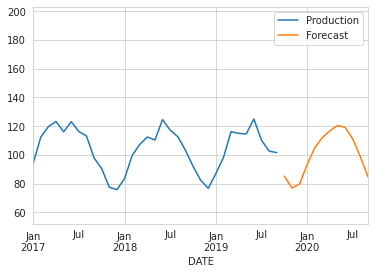

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2017-01-01','2020-09-01')